# IMPORT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

import neptune.new as neptune
from neptune.new.types import File
import optuna
import neptune.new.integrations.optuna as optuna_utils
import uuid

# DEFINE

In [2]:
DATA_PATH   = '../data/'
RANDOM_SEED = 42

In [14]:
df = pd.read_csv(DATA_PATH+'prep_data.csv')
df

,Ranking,Rating,Number_of_Reviews,ID_TA,sample,Restaurant_network,Country_code,City_code,Population,Capital,num_of_cuisine_styles,Price
0,5570.0,3.5,194.0,1912643,1,1,5,24,2190327,1,3,2
1,1537.0,4.0,10.0,7992032,1,1,20,27,961609,1,1,2
2,353.0,4.5,688.0,8632781,1,1,22,16,8908081,1,7,3
3,3458.0,5.0,3.0,1358776,1,1,6,3,3644826,1,1,2
4,621.0,4.0,84.0,6864963,1,1,6,21,1456039,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4367.0,NaN,28.0,11916827,0,1,22,16,8908081,1,4,1
49996,2612.0,NaN,2.0,12701633,0,0,15,14,505526,1,4,2
49997,5562.0,NaN,2.0,13198194,0,0,10,20,1378689,0,1,2
49998,4010.0,NaN,2.0,3862815,0,0,10,20,1378689,0,1,2


# Usefull functions

In [4]:
def rating(prediction):
    
    """ Округляет рейтинг """
    
    if prediction < 0.25:
        return 0
    elif 0.25 < prediction <= 0.75:
        return 0.5
    elif 0.75 < prediction <= 1.25:
        return 1
    elif 1.25 <prediction <= 1.75:
        return 1.5
    elif 1.75 < prediction <= 2.25:
        return 2
    elif 2.25 < prediction <= 2.75:
        return 2.5
    elif 2.75 < prediction <= 3.25:
        return 3
    elif 3.25 < prediction <= 3.75:
        return 3.5
    elif 3.75 < prediction <= 4.25:
        return 4
    elif 4.25 < prediction <= 4.75:
        return 4.5
    else:
        return 5

In [5]:
def eval_metrics(actual, prediction):
    
    """ Метрики """
    
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    mae = mean_absolute_error(actual, prediction)
    r2 = r2_score(actual, prediction)
#     mape = mean_absolute_percentage_error(actual, prediction)
    
    return rmse, mae, r2

# Optuna hyperparams search

In [42]:
# Optuna
def objective(trial):
    # Define
    RANDOM_SEED = 42
    
    # Data
    X = df[df['sample'] == 1].drop(['Rating'], axis=1)
    X.drop(['sample'], axis=1, inplace=True)
    y = df['Rating'][df['sample'] == 1]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    
    # Params for search
    n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
    
    # Model
    RFR = RandomForestRegressor(n_estimators = n_estimators, n_jobs=-1, random_state=RANDOM_SEED)
    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_test)
    
    for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])
        
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    trial.set_user_attr('RANDOM_SEED', RANDOM_SEED)
    trial.set_user_attr('rmse', rmse)
    trial.set_user_attr('r2', r2)

    return mae

def callback(study, trial):
    study.set_user_attr(key="RANDOM_SEED", value=trial.user_attrs["RANDOM_SEED"])
    study.set_user_attr(key="rmse", value=trial.user_attrs["rmse"])
    study.set_user_attr(key="r2", value=trial.user_attrs["r2"])

In [44]:
# Start optuna search with neptune logging
run = neptune.init(project='alxkzncoff/rest-rating',
                       tags=['random_forest', 'optuna'],
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmI4NDE1Ny03YzcyLTQwOTQtOTUwMi1kODlkYWMwY2YwOGQifQ==',
                       name = 'random_forest')
    
neptune_callback = optuna_utils.NeptuneCallback(run)
    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=2, callbacks=[neptune_callback, callback])

run.stop()

https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-12
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


[I 2021-08-03 15:48:23,276] A new study created in memory with name: no-name-e4855b0d-06a8-489e-a6ba-475f8c913093
[I 2021-08-03 15:48:25,206] Trial 0 finished with value: 0.1822 and parameters: {'n_estimators': 80}. Best is trial 0 with value: 0.1822.
[I 2021-08-03 15:48:29,291] Trial 1 finished with value: 0.18215 and parameters: {'n_estimators': 170}. Best is trial 1 with value: 0.18215.


Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 80 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 80 operations (0.00% done). Please wait.
Still waiting for the remaining 80 operations (0.00% done). Please wait.
Still waiting for the remaining 31 operations (61.25% done). Please wait.
Still waiting for the remaining 31 operations (61.25% done). Please wait.


All 80 operations synced, thanks for waiting!


# Optuna logging all trails

In [6]:
sweep_id = uuid.uuid1()
print("sweep-id: ", sweep_id)

sweep-id:  ae717ec0-f463-11eb-9b22-b42e99be5b3e


In [7]:
run_study_level = neptune.init(project='alxkzncoff/rest-rating',
                        tags=['random_forest', 'optuna'],
                        api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmI4NDE1Ny03YzcyLTQwOTQtOTUwMi1kODlkYWMwY2YwOGQifQ==',
                        name = 'random_forest')

run_study_level["sys/tags"].add("study-level")
run_study_level["sweep-id"] = sweep_id

Info (NVML): Not Supported. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-35
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [10]:
def objective_with_logging(trial):
    
    # Define
    RANDOM_SEED = 42
    
    X = df[df['sample'] == 1].drop(['Rating'], axis=1)
    X.drop(['sample'], axis=1, inplace=True)
    y = df['Rating'][df['sample'] == 1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    
    n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)

    run_trial_level = neptune.init(project='alxkzncoff/rest-rating',
                                   tags=['random_forest', 'optuna'],
                                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmI4NDE1Ny03YzcyLTQwOTQtOTUwMi1kODlkYWMwY2YwOGQifQ==')


    # log parameters of a trial-level Run
    run_trial_level['n_estimators'] = n_estimators

    # run model training
    RFR = RandomForestRegressor(n_estimators = n_estimators, n_jobs=-1, random_state=RANDOM_SEED)
    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_test)
    
    for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])
        
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)

    # log score of a trial-level Run
    run_trial_level["mae"] = mae
    run_trial_level["rmse"] = rmse
    run_trial_level["r2"] = r2
    
    # Plots
    # Feature Importance
    features = X.columns
    importances = RFR.feature_importances_
    indices = np.argsort(importances)
    
    fig = plt.figure(figsize=(10, 8))

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.close(fig)

    run_trial_level['matplotlib-fig'].upload(fig)
    

    # stop trial-level Run
    run_trial_level.stop()

    return mae

In [11]:
neptune_callback = optuna_utils.NeptuneCallback(run_study_level)

study = optuna.create_study(direction="minimize")
study.optimize(objective_with_logging, n_trials=20, callbacks=[neptune_callback])

run_study_level.stop()

[I 2021-08-03 17:04:57,453] A new study created in memory with name: no-name-a50a4f87-6923-4ac3-996f-25da51c55880


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-37
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:02,142] Trial 0 finished with value: 0.18445 and parameters: {'n_estimators': 40}. Best is trial 0 with value: 0.18445.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-38
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:09,475] Trial 1 finished with value: 0.18215 and parameters: {'n_estimators': 170}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-39
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:16,758] Trial 2 finished with value: 0.18285 and parameters: {'n_estimators': 150}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-40
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:24,617] Trial 3 finished with value: 0.1824 and parameters: {'n_estimators': 190}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-41
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:29,509] Trial 4 finished with value: 0.1845 and parameters: {'n_estimators': 30}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-42
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:35,366] Trial 5 finished with value: 0.18325 and parameters: {'n_estimators': 120}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-43
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:40,887] Trial 6 finished with value: 0.1822 and parameters: {'n_estimators': 80}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-44
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:47,674] Trial 7 finished with value: 0.18285 and parameters: {'n_estimators': 150}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-45
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:52,351] Trial 8 finished with value: 0.18465 and parameters: {'n_estimators': 50}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-46
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:05:56,818] Trial 9 finished with value: 0.18445 and parameters: {'n_estimators': 40}. Best is trial 1 with value: 0.18215.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-47
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.


All 5 operations synced, thanks for waiting!


[I 2021-08-03 17:06:05,406] Trial 10 finished with value: 0.1821 and parameters: {'n_estimators': 200}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-48
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:13,532] Trial 11 finished with value: 0.1824 and parameters: {'n_estimators': 190}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-49
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:20,985] Trial 12 finished with value: 0.1821 and parameters: {'n_estimators': 200}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-50
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:29,316] Trial 13 finished with value: 0.1821 and parameters: {'n_estimators': 200}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-51
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:35,758] Trial 14 finished with value: 0.18325 and parameters: {'n_estimators': 120}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-52
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:43,854] Trial 15 finished with value: 0.1822 and parameters: {'n_estimators': 160}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-53
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:52,624] Trial 16 finished with value: 0.1821 and parameters: {'n_estimators': 200}. Best is trial 10 with value: 0.1821.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-54
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:06:58,283] Trial 17 finished with value: 0.18205 and parameters: {'n_estimators': 90}. Best is trial 17 with value: 0.18205.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-55
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:07:04,663] Trial 18 finished with value: 0.18205 and parameters: {'n_estimators': 90}. Best is trial 17 with value: 0.18205.


https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-56
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 20 operations to synchronize with Neptune. Do not kill this process.


All 20 operations synced, thanks for waiting!


[I 2021-08-03 17:07:10,515] Trial 19 finished with value: 0.1822 and parameters: {'n_estimators': 80}. Best is trial 17 with value: 0.18205.


Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 827 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 479 operations (42.08% done). Please wait.
Still waiting for the remaining 479 operations (42.08% done). Please wait.


All 827 operations synced, thanks for waiting!


In [49]:
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [50]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.210
1,id_1,4.330
2,id_2,4.355
3,id_3,4.375
4,id_4,4.410
...,...,...
9995,id_9995,4.470
9996,id_9996,4.120
9997,id_9997,3.005
9998,id_9998,4.500


In [51]:
X = df[df['sample'] == 1].drop(['Rating'], axis=1)
X.drop(['sample'], axis=1, inplace=True)
y = df['Rating'][df['sample'] == 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [52]:
RFR = RandomForestRegressor(n_estimators = 90, n_jobs=-1, random_state=RANDOM_SEED)
RFR.fit(X_train, y_train)
y_pred = RFR.predict(X_test)

for i in range(y_pred.size):
    y_pred[i]=rating(y_pred[i])
        
(rmse, mae, r2) = eval_metrics(y_test, y_pred)

print(f'RMSE: {np.round(rmse, 6)} | MAE: {np.round(mae, 6)} | R2: {np.round(r2, 6)}')

RMSE: 0.337231 | MAE: 0.18205 | R2: 0.739697


In [53]:
test = df[df['sample']==0]

In [54]:
test

,Ranking,Rating,Number_of_Reviews,ID_TA,sample,Restaurant_network,Country_code,City_code,Population,Capital,num_of_cuisine_styles,Price
40000,12963.0,NaN,4.0,10746918,0,1,5,24,2190327,1,2,2
40001,106.0,NaN,97.0,6674944,0,1,4,12,643272,1,5,2
40002,810.0,NaN,28.0,13129638,0,1,16,9,488100,1,1,2
40003,1669.0,NaN,202.0,680417,0,1,22,16,8908081,1,5,3
40004,37.0,NaN,162.0,1112354,0,1,17,4,432864,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4367.0,NaN,28.0,11916827,0,1,22,16,8908081,1,4,1
49996,2612.0,NaN,2.0,12701633,0,0,15,14,505526,1,4,2
49997,5562.0,NaN,2.0,13198194,0,0,10,20,1378689,0,1,2
49998,4010.0,NaN,2.0,3862815,0,0,10,20,1378689,0,1,2


In [55]:
X_submission = test.drop(['Rating', 'sample'], axis=1)
y_submission = RFR.predict(X_submission)

In [56]:
for i in range(y_pred.size):
    y_submission[i]=rating(y_submission[i])

In [57]:
sample_submission['Rating'] = y_submission
sample_submission.to_csv('../data/random_forest_90.csv', index=False)

In [59]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [17]:
def neptune_random_forest(data, n_estimators, RANDOM_SEED):
    
    df = data.copy()
    df.reset_index(inplace=True)
    
    run = neptune.init(project='alxkzncoff/rest-rating',
                       tags='random_forest',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmI4NDE1Ny03YzcyLTQwOTQtOTUwMi1kODlkYWMwY2YwOGQifQ==',
                       name = 'random_forest')
    
    neptune_callback = optuna_utils.NeptuneCallback(run)
    
    ######################## Split #########################
    
    X = df[df['sample'] == 1].drop(['Rating'], axis=1)
    X.drop(['sample'], axis=1, inplace=True)
    y = df['Rating'][df['sample'] == 1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    
    ######################## Model #########################
    
    RFR = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=RANDOM_SEED)
    
    ######################## Fit #########################
    
    RFR.fit(X_train, y_train)
    
    ######################## Predict #########################
    
    y_pred = RFR.predict(X_test)
    
    for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])
        
    (rmse, mae, r2) = eval_metrics(y_test, y_pred)
    
    ######################## Neptune logs #########################
    
    # Metrics
    run['metric/rmse'].log(np.round(rmse, 3))
    run['metric/mae'].log(np.round(mae, 3))
    run['metric/r2'].log(np.round(r2, 3))
    
    # Parameters 
    PARAMS = RFR.get_params()
    
    run['parameters'] = PARAMS

    # Plots
    # Feature Importance
    features = X.columns
    importances = RFR.feature_importances_
    indices = np.argsort(importances)
    
    fig = plt.figure(figsize=(10, 8))

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')

    run['matplotlib-fig'].upload(fig)
    
    print(f'RMSE: {np.round(rmse, 3)} | MAE: {np.round(mae, 3)} | R2: {np.round(r2, 3)}')

    run.stop()
    
    return y_pred

https://app.neptune.ai/alxkzncoff/rest-rating/e/RES-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
RMSE: 0.339 | MAE: 0.183 | R2: 0.736
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 40 operations to synchronize with Neptune. Do not kill this process.


All 40 operations synced, thanks for waiting!


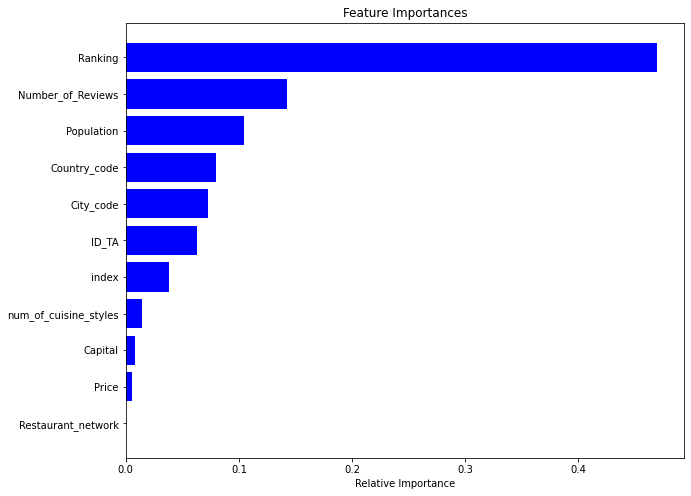

In [18]:
y_pred = neptune_random_forest(df, 100, RANDOM_SEED)